In [1]:
# importing libraires 
import numpy as np
import pandas as pd 
import os 
import tensorflow as tf 
import librosa as lb 
import matplotlib.pyplot as plt


from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import Sequential , layers 

from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix , classification_report 
import IPython.display as ipd

# 1) Ses Dosyalarının Veri Önişlemesi

Öncelikle Librosa ile bir ses dosyası örneğini inceleyelim.

In [2]:
import librosa
audio_file_path='UrbanSound8K/audio/fold5/100263-2-0-3.wav'
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)

In [3]:
print(librosa_audio_data)

[ 0.00327535  0.00470622  0.00359118 ... -0.00371737 -0.00352591
 -0.0035292 ]


In [4]:
import matplotlib
matplotlib.__version__

'3.6.0'

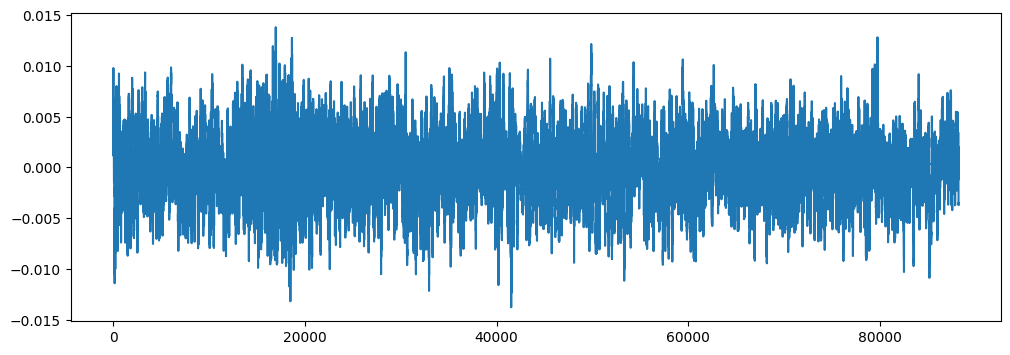

In [5]:
### ses dosyasının plot unu çizdirelim.
import matplotlib.pyplot as plt
# kanal 1 orjinal ses 
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

Librosa burada sinyali mono ya çeviriyor yani kanal 1 oluyor.

In [6]:
# scipy kullanarak okuyalım.
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(audio_file_path) 

In [7]:
wave_audio

array([[ 194,  100],
       [ 179,  113],
       [ 160,  124],
       ...,
       [-143,  -87],
       [-134,  -91],
       [-110,  -98]], dtype=int16)

Şimdide 2 kanal ile birlikte incelemesine bakalım.

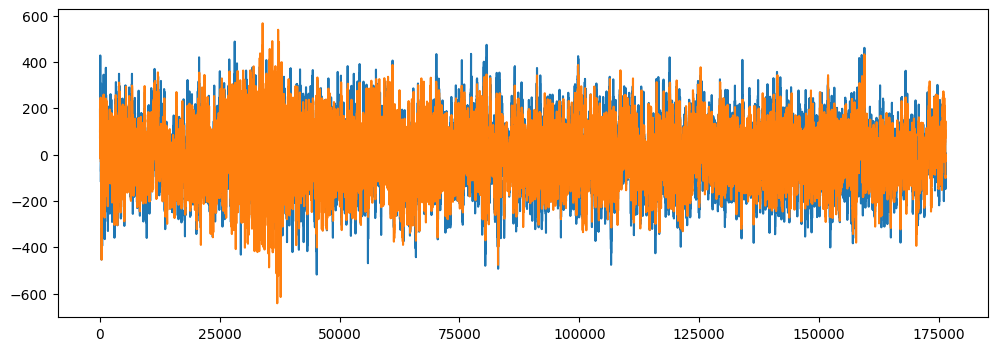

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)

Dosyalardan çıkaracağımız özellikler: Burada ses örneklerinden Mel-Frekans Cepstral Katsayılarını (MFCC) kullanarak devam edeceğiz. MFCC, window size boyunca frekans dağılımını özetler, böylece sesin hem frekans hem de zaman özelliklerini analiz etmek mümkün olabilir. Bu ses temsil örneklemleri, sınıflandırma için özellikleri tanımlamamıza izin verecektir.

In [9]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 173)


In [10]:
mfccs

array([[-4.76983704e+02, -4.54081116e+02, -4.52210968e+02, ...,
        -4.80044495e+02, -4.75459564e+02, -4.91704163e+02],
       [ 1.18308380e+02,  1.15959877e+02,  1.15713654e+02, ...,
         1.15763275e+02,  1.13561340e+02,  1.04188065e+02],
       [-2.13244038e+01, -2.91875725e+01, -3.47086411e+01, ...,
        -1.28605833e+01, -1.20376625e+01, -5.69748783e+00],
       ...,
       [-2.17649603e+00, -2.13805151e+00, -4.00922489e+00, ...,
         3.15195084e-01,  3.51473784e+00,  7.31593561e+00],
       [-1.06117368e+00, -1.59224260e+00, -1.59619093e+00, ...,
        -5.39945841e-01,  9.07175303e-01,  2.92428374e+00],
       [-6.15001082e-01,  1.59921455e+00,  7.02612257e+00, ...,
        -2.00688767e+00, -5.01438046e+00, -3.42770672e+00]], dtype=float32)

In [11]:

data = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')

In [12]:
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


In [14]:
# preprocessing 
classes = data.groupby('classID')['class']
classes.unique()

classID
0     [air_conditioner]
1            [car_horn]
2    [children_playing]
3            [dog_bark]
4            [drilling]
5       [engine_idling]
6            [gun_shot]
7          [jackhammer]
8               [siren]
9        [street_music]
Name: class, dtype: object

In [15]:
data['class'].unique()

array(['dog_bark', 'children_playing', 'car_horn', 'air_conditioner',
       'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer',
       'drilling'], dtype=object)

Şimdide tüm audio file ları incelemek için bir fonksiyon yazalım, tabiki döngüye sokarak tüm ses dosyalarını alabileceğiz.

In [16]:
def feature_extract(path):
    data , sample = lb.load(path)
    data = lb.feature.mfcc(data , n_mfcc = 128) # Mel-frequency cepstral coefficients (MFCCs) => Çoklu kanal için mfcc (Mel spectrogram)
                                                                                                              # n_mfcc: int > 0 [scalar]
                                                                                                              # number of MFCCs to return
     # lb.feature.mfcc => seçilen eksen boyunca girdi verilerinin türevinin yerel tahmini. (Savitsky-Golay filtrelemesi ile)                                                                                                          
    data = np.mean(data , axis = 1)
    return data
print(len(data))

8732


In [17]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #Sürekli gelen warning mesajı !!!
# Şimdi her ses dosyasını yineliyoruz ve özellikleri çıkarıyoruz
# Mel-Frekans Cepstral Katsayılarını kullanıyoruz.


x = []
y = [] 

for i in range(len(data)):
    path = "UrbanSound8K/audio/" + "fold" + str(data.loc[i , 'fold']) +"/" + str(data.loc[i , "slice_file_name"])
    x.append(feature_extract(path))
    y.append(data.loc[i , 'classID'])
    if(i%100 == 0):
        print(i)
        

X = np.array(x)

y = np.array(y)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500


c:\Users\okan_\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)


3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300


c:\Users\okan_\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
c:\Users\okan_\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)


8400
8500
8600
8700


In [18]:
# y numpy dizisi içindeki verileri encode etmemiz lazım to_categorical bunu yapıyor.
y = to_categorical(y)
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

**Veri setinin eğitim ve test veri seti olarak ikiye bölünmesi**

In [19]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , random_state = 42)

In [20]:
X_train

array([[-8.50379410e+01,  1.11482803e+02, -9.27119675e+01, ...,
        -2.19389305e-01,  1.01927891e-01, -2.15174392e-01],
       [-1.58553406e+02,  1.28770035e+02, -2.05113907e+01, ...,
         1.04132436e-01, -1.33280344e-02, -5.95130920e-02],
       [-2.62358887e+02,  1.76666946e+02, -1.12569252e+02, ...,
        -5.12983263e-01, -1.09881267e-01, -8.30067135e-03],
       ...,
       [-2.91080566e+02,  2.33202850e+02, -4.68367577e+00, ...,
        -1.47355449e+00, -2.47372484e+00, -2.12185693e+00],
       [-1.97276108e+02,  8.70481186e+01, -7.45400162e+01, ...,
         1.32265890e+00,  6.12522483e-01, -2.46352702e-01],
       [-2.66952850e+02,  1.28927475e+02, -2.35177660e+00, ...,
        -1.98932718e-02, -2.06106585e-02,  1.28786474e-01]], dtype=float32)

In [21]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [22]:
X_train.shape

(6985, 128)

In [23]:
X_test.shape

(1747, 128)

In [24]:
y_train.shape

(6985, 10)

In [25]:
y_test.shape

(1747, 10)

In [26]:
print(tf.__version__)

2.10.0
